In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

SMALL_SIZE = 25
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE +2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Constants
D_rho = 2.2e-5  # kg/ms
R = 8.314  # J/K*mol
dM = 0.003  # kg/mol
M = 0.352  # kg/mol of UF6
M_atm = 0.238  # atomic mass of natural uranium

# Centrifuge assumptions
x = 1000  # pressure ratio (Glaser)
k = 2.0  # L/F ratio

# Centrifuge parameters
# v_a = 485.0 # m/s
# Z = 1.0   # m
# d = 0.15  # m
# F_m = 15e-6 # kg/s (paper is in mg/s)
#r_12 = 0.746


def calc_del_U(cut):
    
    Z = 0.5
    d = 0.15
    v_a = 485.0
    F_m = 15.0*1e-6
    T = 320.0
    eff = 1.0
    verbose=False
    a = d / 2.0  # outer radius
    r_2 = 0.975 * a  # fraction of a

    # Intermediate calculations
    r_12 = np.sqrt(1.0 - (2.0 * R * T * (np.log(x)) / M / (v_a**2)))  # fraction
    r_1 = r_2 * r_12  # fraction

    # Glaser eqn 12
    L_F = k  # range 2-4
    Z_p = Z * (1.0 - cut) * (1.0 + L_F) / (1.0 - cut + L_F)

    if (verbose == True):
        print("L_F= ", L_F)
        print("Z_p=  ", Z_p)
        print("r_1", r_1)
        print("r_12", r_12)

    # Glaser eqn 3
    # To convert from gas to atom fraction, multiple by M_atm/M
    C1 = (2.0 * np.pi * (D_rho * M_atm / M) / (np.log(r_2 / r_1)))
#    C1 = (2.0*np.pi*(D_rho)/(np.log(r_2/r_1)))
    A_p = C1 * (1.0 / F_m) * (cut / ((1.0 + L_F) * (1.0 - cut + L_F)))
    A_w = C1 * (1.0 / F_m) * ((1.0 - cut) / (L_F * (1.0 - cut + L_F)))

    C_flow = 0.5 * F_m * cut * (1.0 - cut)
    C_therm = calc_C_therm(v_a, T)

    C_scale = ((r_2 / a)**4) * ((1 - (r_12**2))**2)
    bracket1 = (1 + L_F) / cut
    exp1 = np.exp(-1.0 * A_p * Z_p)
    bracket2 = L_F / (1 - cut)
    exp2 = np.exp(-1.0 * A_w * (Z - Z_p))

    # Glaser eqn 10
    # Efficiency applied to optimal del_U in Ratz p73 (pdf p21)
    major_term = 0.5 * cut * (1.0 - cut) * (C_therm**2) * C_scale * (
        (bracket1 * (1 - exp1)) + (bracket2 * (1 - exp2)))**2  # kg/s
    del_U = F_m * major_term * eff  # kg/s

    per_sec2yr = 60 * 60 * 24 * 365.25  # s/m * m/hr * hr/d * d/y

    # Glaser eqn 6
    dirac = 0.5 * np.pi * Z * (D_rho * M_atm / M) * \
        (C_therm**2) * per_sec2yr  # kg/s
    del_U_yr = del_U * per_sec2yr

    # Avery p.18
    #alpha = alpha_by_swu(del_U, F_m, cut)

    return del_U#, del_U_yr, dirac  # kg/sec

# for a machine


def calc_C_therm(v_a, T):
    C_therm = (dM * (v_a**2)) / (2.0 * R * T)
    return C_therm


def calc_V(N_in):
    V_out = (2.0 * N_in - 1.0) * np.log(N_in / (1.0 - N_in))
    return V_out


def alpha_by_swu(cut):
    # avery p.18
    # del_u in moles/sec
    F_m = 15.0*1e-6

    del_u_moles = calc_del_U(cut) / M
    alpha = 1 + np.sqrt((2 * del_u_moles * (1 - cut) / (cut * F_m)))
    return alpha

def nprime_by_alpha(alpha, N):
    return alpha*N/(1-N+alpha*N)

def nsecond_by_cut(cut, N_prime, N):
    return(N - cut*N_prime)/(1-cut)

def R_(N):
    return N/(1-N)

def beta_by_alpha(cut, N):
    alpha = alpha_by_swu(cut)
    N_prime = nprime_by_alpha(alpha, N)
    N_second = nsecond_by_cut(cut, N_prime, N)
    beta = R_(N)/R_(N_second)
    return beta


from scipy import optimize as opt

def a_b_zero(N):
    def func(x):
        return alpha_by_swu(x) - beta_by_alpha(x,N)
    
    a =(opt.fsolve( func, 0.5))
    return a

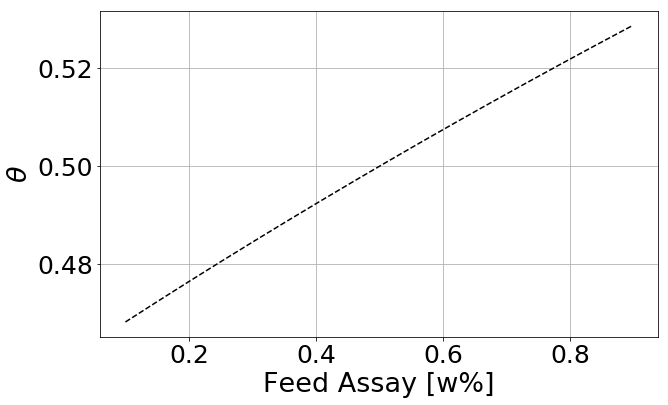

In [5]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.1, 0.9, 0.001)
y = [a_b_zero(v) for v in t]

plt.grid()
plt.plot(t, y, 'k--')
plt.ylabel(r'${\theta}$')
plt.xlabel("Feed Assay [w%]")


#plt.legend()
#plt.savefig(filename="test.png")
plt.show()